### Vary bias in data $\mathbf{X}$
Estimate the precision matrix for a fair graph with increasingly biased data.

In [84]:
from opt import *
from plt_utils import *
from time import perf_counter

import pickle

from joblib import Parallel, delayed
import os

from sklearn.covariance import graphical_lasso

import pandas as pd
from torch_geometric.utils import to_networkx, to_dense_adj

SEED = 1212
SAVE = True
PATH = './results/ablation1'
N_CPUS = os.cpu_count() // 2
np.random.seed(SEED)

os.environ['OMP_NUM_THREADS'] = str(N_CPUS)

def rewire_precmat(Theta, rewire=3, replace=False):
    p,p = Theta.shape
    theta = mat2lowtri(Theta)
    if not replace:
        for _ in range(rewire):
            ix = np.random.choice(len(theta),2,replace=replace)
            theta[[ix[0],ix[1]]] = theta[[ix[1],ix[0]]]
    else:
        ix = np.random.choice(len(theta), 2*rewire, replace=replace)
        for i in range(rewire):
            theta[[ix[i],ix[rewire+i]]] = theta[[ix[rewire+i],ix[i]]]
    Theta_rw = lowtri2mat(theta) + Theta*np.eye(p)
    return Theta_rw

In [85]:
edge_prob = .1
p = 50
n = 10000
g = 2

eps_bias = 1e-3
BIAS_RANGE = np.linspace(0,.5,5)
num_params = len(BIAS_RANGE)

mu1 = .1
mu2 = 100
epsilon = 1e-6
bias_type = 'dp'
eta = .02
iters = 1000

num_trials = 10

z = np.ones(p, dtype=int)
z[:int(p/2)] = 0
Z = np.eye(g)[z].T

In [87]:
verbose = True
num_trials = 10
lo_ratio = .2
hi_ratio = .6

# Parameter choice before tuning (done via grid search)
mu1_range = np.sqrt(1/n)*np.ones(5)
mu2_range = np.array([50,50,50,50,50])

gl_mu1 = mu1_range
dp_mu1 = mu1_range
nw_mu1 = mu1_range
eus_mu1 = mu1_range
eusdp_mu1 = mu1_range
eusnw_mu1 = mu1_range

dp_mu2 = mu2_range
nw_mu2 = mu2_range
eusdp_mu2 = mu2_range
eusnw_mu2 = mu2_range

gl_params = [{
    'mu1':gl_mu1[i],
    'eta':1e-2,
    'mu2':0,
    'bias_type':'dp',
    'epsilon':.1,
    'iters':5000,
    'EARLY_STOP':True
} for i in range(num_params)]

dp_params = [{
    'mu1':dp_mu1[i],
    'eta':1e-2,
    'mu2':dp_mu2[i],
    'bias_type':'dp',
    'epsilon':.1,
    'iters':5000,
    'EARLY_STOP':True
} for i in range(num_params)]

nw_params = [{
    'mu1':nw_mu1[i],
    'eta':1e-2,
    'mu2':nw_mu2[i],
    'bias_type':'nodewise',
    'epsilon':.1,
    'iters':5000,
    'EARLY_STOP':True
} for i in range(num_params)]

eus_params = [{
    'alpha':eus_mu1[i],
    'beta':0,
    'bias_type':'dp',
    'mu':1e4
} for i in range(num_params)]

eusdp_params = [{
    'alpha':eusdp_mu1[i],
    'beta':eusdp_mu2[i],
    'bias_type':'dp',
    'mu':1e4
} for i in range(num_params)]

eusnw_params = [{
    'alpha':eusnw_mu1[i],
    'beta':eusnw_mu2[i],
    'bias_type':'nodewise',
    'mu':1e4
} for i in range(num_params)]

rwlo = int(lo_ratio*kchoose2(p))
rwhi = int(hi_ratio*kchoose2(p))


In [88]:
def run_trial_biasdata(t:int, data_params, BIAS_RANGE, params, verb:bool=False):
    gl_params = params['gl']
    dp_params = params['dp']
    nw_params = params['nw']
    eus_params = params['eus']
    eusdp_params = params['eusdp']
    eusnw_params = params['eusnw']
    rwlo = params['rwlo']
    rwhi = params['rwhi']

    p = data_params['p']
    n = data_params['n']
    edge_prob = data_params['edge_prob']

    # ------------------------------
    Thetas_true = []
    Thetas_bias = []
    Thetas_all = dict(zip(['gl','dp','nwdp','st','stdp','stnwdp','rwlo','rwhi'],[None]*7))
    times_all = dict(zip(['gl','dp','nwdp','st','stdp','stnwdp','rwlo','rwhi'],[None]*7))
    Xs_all = []
    Xs_bias = []
    Bs_all = []

    num_params = len(BIAS_RANGE)

    Thetas_gl = []
    Thetas_dp = []
    Thetas_nw = []
    Thetas_eus = []
    Thetas_eusdp = []
    Thetas_eusnw = []
    Thetas_rwlo = []
    Thetas_rwhi = []
    
    time_gl = np.zeros(num_params)
    time_dp = np.zeros(num_params)
    time_nw = np.zeros(num_params)
    time_eus = np.zeros(num_params)
    time_eusdp = np.zeros(num_params)
    time_eusnw = np.zeros(num_params)
    time_rwlo = np.zeros(num_params)
    time_rwhi = np.zeros(num_params)
    # ------------------------------

    # ------------------------------
    A = generate_connected_er(p,edge_prob)
    Sigma = create_gmrf_cov(A)
    Theta = np.linalg.inv(Sigma)
    Theta_od = Theta*(1-np.eye(p))
    X = np.random.multivariate_normal(np.zeros(p), Sigma, n)
    Sigma_hat = X.T@X/n
    Thetas_true = Theta.copy()
    Xs_all = X.copy()

    z = np.ones(p, dtype=int)
    z[:int(p/2)] = 0
    Z = np.eye(g)[z].T

    mask_Z = [[(Z[a][:,None]*Z[b][None])*(1-np.eye(p)) for b in range(g)] for a in range(g)]
    ccalZ = [[np.where(mask_Z[a][b]==1) for b in range(g)] for a in range(g)]

    B = np.mean(np.diag(Theta))*np.ones_like(Theta)
    for a in range(g):
        for b in range(g):
            B[ccalZ[a][b]] = eps_bias-1 if a==b else -eps_bias
    while np.min(np.linalg.eigh(B)[0]) < 0:
        B[np.eye(p)==0] *= .99
    Bs_all = B.copy()
    # ------------------------------

    for i,lmbda in enumerate(BIAS_RANGE):
        print(f"Bias level: {lmbda:.4f} | Trial {t+1} of {num_trials}")

        # ------------------------------
        Theta_bias = (1-lmbda)*Theta + lmbda*B
        Sigma_bias = np.linalg.inv(Theta_bias)
        X_bias = np.random.multivariate_normal(np.zeros(p), Sigma_bias, n)
        Sigma_bias_hat = X_bias.T@X_bias/n
        Thetas_bias.append(Theta_bias)
        Xs_bias.append(X_bias)
        # ------------------------------

        # ------------------------------
        # GLASSO
        tic = perf_counter()
        Theta_gl = FairGLASSO_fista(Sigma_bias_hat, Z=Z, **gl_params[i])
        Theta_gl_od = Theta_gl * (1-np.eye(p))
        toc = perf_counter()
        if verb:
            frob = compute_frob_err(Theta_gl_od, Theta_od)
            bias = np.sqrt(compute_dp2(Theta_gl_od,Z))
            if np.mean(np.abs(mat2lowtri(Theta_gl_od)))>1e-6:
                bias /= np.mean(np.abs(mat2lowtri(Theta_gl_od)))
            print( f'    ' + 
                   f'GLASSO:            '
                   f'Err: {frob:.4f} | ' + 
                   f'Bias: {bias:.4f}')
        Thetas_gl.append( Theta_gl )
        time_gl[i] = np.abs(toc-tic)
        # ------------------------------
        
        
        # ------------------------------
        # Fair GLASSO with DP
        tic = perf_counter()
        Theta_dp = FairGLASSO_fista(Sigma_bias_hat, Z=Z, **dp_params[i])
        Theta_dp_od = Theta_dp * (1-np.eye(p))
        toc = perf_counter()
        if verb:
            frob = compute_frob_err(Theta_dp_od, Theta_od)
            bias = np.sqrt(compute_dp2(Theta_dp_od,Z))
            if np.mean(np.abs(mat2lowtri(Theta_dp_od)))>1e-6:
                bias /= np.mean(np.abs(mat2lowtri(Theta_dp_od)))
            print( f'    ' + 
                   f'DP:                '
                   f'Err: {frob:.4f} | ' + 
                   f'Bias: {bias:.4f}')
        Thetas_dp.append( Theta_dp )
        time_dp[i] = np.abs(toc-tic)
        # ------------------------------
        
        
        # ------------------------------
        # Fair GLASSO with Nw. DP
        tic = perf_counter()
        Theta_nw = FairGLASSO_fista(Sigma_bias_hat, Z=Z, **nw_params[i])
        Theta_nw_od = Theta_nw * (1-np.eye(p))
        toc = perf_counter()
        if verb:
            frob = compute_frob_err(Theta_nw_od, Theta_od)
            bias = np.sqrt(compute_dp2(Theta_nw_od,Z))
            if np.mean(np.abs(mat2lowtri(Theta_nw_od)))>1e-6:
                bias /= np.mean(np.abs(mat2lowtri(Theta_nw_od)))
            print( f'    ' + 
                   f'Nw. DP:            '
                   f'Err: {frob:.4f} | ' + 
                   f'Bias: {bias:.4f}')
        Thetas_nw.append( Theta_nw )
        time_nw[i] = np.abs(toc-tic)
        # ------------------------------
        
        
        # ------------------------------
        # SpecTemp
        tic = perf_counter()
        Theta_eus = FGSR(Sigma_bias_hat, Z=Z, **eus_params[i])
        Theta_eus_od = Theta_eus * (1-np.eye(p))
        toc = perf_counter()
        if verb:
            frob = compute_frob_err(Theta_eus_od, Theta_od)
            bias = np.sqrt(compute_dp2(Theta_eus_od,Z))
            if np.mean(np.abs(mat2lowtri(Theta_eus_od)))>1e-6:
                bias /= np.mean(np.abs(mat2lowtri(Theta_eus_od)))
            print( f'    ' + 
                   f'SpecTemp:          '
                   f'Err: {frob:.4f} | ' + 
                   f'Bias: {bias:.4f}')
        Thetas_eus.append( Theta_eus )
        time_eus[i] = np.abs(toc-tic)
        # ------------------------------
        
        
        # ------------------------------
        # Fair SpecTemp with DP
        tic = perf_counter()
        Theta_eusdp = FGSR(Sigma_bias_hat, Z=Z, **eusdp_params[i])
        Theta_eusdp_od = Theta_eusdp * (1-np.eye(p))
        toc = perf_counter()
        if verb:
            frob = compute_frob_err(Theta_eusdp_od, Theta_od)
            bias = np.sqrt(compute_dp2(Theta_eusdp_od,Z))
            if np.mean(np.abs(mat2lowtri(Theta_eusdp_od)))>1e-6:
                bias /= np.mean(np.abs(mat2lowtri(Theta_eusdp_od)))
            print( f'    ' + 
                   f'SpecTemp + DP:     '
                   f'Err: {frob:.4f} | ' + 
                   f'Bias: {bias:.4f}')
        Thetas_eusdp.append( Theta_eusdp )
        time_eusdp[i] = np.abs(toc-tic)
        # ------------------------------
        
        
        # ------------------------------
        # Fair SpecTemp with Nw. DP
        tic = perf_counter()
        Theta_eusnw = FGSR(Sigma_bias_hat, Z=Z, **eusnw_params[i])
        Theta_eusnw_od = Theta_eusnw * (1-np.eye(p))
        toc = perf_counter()
        if verb:
            frob = compute_frob_err(Theta_eusnw_od, Theta_od)
            bias = np.sqrt(compute_dp2(Theta_eusnw_od,Z))
            if np.mean(np.abs(mat2lowtri(Theta_eusnw_od)))>1e-6:
                bias /= np.mean(np.abs(mat2lowtri(Theta_eusnw_od)))
            print( f'    ' + 
                   f'SpecTemp + Nw. DP: '
                   f'Err: {frob:.4f} | ' + 
                   f'Bias: {bias:.4f}')
        Thetas_eusnw.append( Theta_eusnw )
        time_eusnw[i] = np.abs(toc-tic)
        # ------------------------------
        
        
        # ------------------------------
        # GLASSO + rewiring few edges
        tic = perf_counter()
        Theta_rwlo = rewire_precmat( Theta_gl, rewire=rwlo, replace=True )
        Theta_rwlo_od = Theta_rwlo * (1-np.eye(p))
        toc = perf_counter()
        if verb:
            frob = compute_frob_err(Theta_rwlo_od, Theta_od)
            bias = np.sqrt(compute_dp2(Theta_rwlo_od,Z))
            if np.mean(np.abs(mat2lowtri(Theta_rwlo_od)))>1e-6:
                bias /= np.mean(np.abs(mat2lowtri(Theta_rwlo_od)))
            print( f'    ' + 
                   f'GLASSO + Rw. {rwlo}:   '
                   f'Err: {frob:.4f} | ' + 
                   f'Bias: {bias:.4f}')
        Thetas_rwlo.append( Theta_rwlo )
        time_rwlo[i] = np.abs(toc-tic)
        # ------------------------------
        
        
        # ------------------------------
        # GLASSO + rewiring few edges
        tic = perf_counter()
        Theta_rwhi = rewire_precmat( Theta_gl, rewire=rwhi, replace=True )
        Theta_rwhi_od = Theta_rwhi * (1-np.eye(p))
        toc = perf_counter()
        if verb:
            frob = compute_frob_err(Theta_rwhi_od, Theta_od)
            bias = np.sqrt(compute_dp2(Theta_rwhi_od,Z))
            if np.mean(np.abs(mat2lowtri(Theta_rwhi_od)))>1e-6:
                bias /= np.mean(np.abs(mat2lowtri(Theta_rwhi_od)))
            print( f'    ' + 
                   f'GLASSO + Rw. {rwhi}:   '
                   f'Err: {frob:.4f} | ' + 
                   f'Bias: {bias:.4f}')
        Thetas_rwhi.append( Theta_rwhi )
        time_rwhi[i] = np.abs(toc-tic)
        # ------------------------------

        if verb:
            print()
        
    Thetas_all['gl'] = Thetas_gl
    Thetas_all['dp'] = Thetas_dp
    Thetas_all['nwdp'] = Thetas_nw
    Thetas_all['st'] = Thetas_eus
    Thetas_all['stdp'] = Thetas_eusdp
    Thetas_all['stnwdp'] = Thetas_eusnw
    Thetas_all['rwlo'] = Thetas_rwlo
    Thetas_all['rwhi'] = Thetas_rwhi

    times_all['gl'] = time_gl
    times_all['dp'] = time_dp
    times_all['nwdp'] = time_nw
    times_all['st'] = time_eus
    times_all['stdp'] = time_eusdp
    times_all['stnwdp'] = time_eusnw
    times_all['rwlo'] = time_rwlo
    times_all['rwhi'] = time_rwhi

    return Thetas_all, Thetas_true, Thetas_bias, \
           times_all, Xs_all, Xs_bias, Bs_all


In [89]:
# ------------------------------
data_params = {
    'n':n,
    'p':p,
    'edge_prob':edge_prob
}
# ------------------------------
params = {
    'gl':gl_params,
    'dp':dp_params,
    'nw':nw_params,
    'eus':eus_params,
    'eusdp':eusdp_params,
    'eusnw':eusnw_params,
    'rwlo':rwlo,
    'rwhi':rwhi
}
# ------------------------------

verb = False

# # ------------------------------
print(f'CPUs employed: {N_CPUS}')
t_init = perf_counter()
results = Parallel(n_jobs=N_CPUS)(delayed(run_trial_biasdata)(t,data_params,BIAS_RANGE,params,verb) for t in range(num_trials))
ellapsed_t = (perf_counter()-t_init)/60
print(f" --- Solved in {ellapsed_t:.3f} minutes --- ")
# # ------------------------------


CPUs employed: 12
Bias level: 0.0000 | Trial 2 of 10
Bias level: 0.0000 | Trial 1 of 10
Bias level: 0.0000 | Trial 7 of 10
Bias level: 0.0000 | Trial 9 of 10
Bias level: 0.0000 | Trial 3 of 10
Bias level: 0.0000 | Trial 5 of 10
Bias level: 0.0000 | Trial 6 of 10
Bias level: 0.0000 | Trial 4 of 10
Bias level: 0.0000 | Trial 10 of 10
Bias level: 0.0000 | Trial 8 of 10


KeyboardInterrupt: 

In [73]:
Thetas_all = [None]*num_trials
Thetas_true = [None]*num_trials
Thetas_bias = [None]*num_trials
Xs_all = [None]*num_trials
Xs_bias = [None]*num_trials
Bs_all = [None]*num_trials
times_all = [None]*num_trials

KEYS = ['gl', 'dp', 'nwdp', 'st', 'stdp', 'stnwdp', 'rwlo', 'rwhi']

for t in range(num_trials):
    Thetas_all[t], Thetas_true[t], Thetas_bias[t], times_all[t], Xs_all[t], Xs_bias[t], Bs_all[t] = results[t]

frob_all = {k:np.array([[compute_frob_err(Thetas_all[t][k][i]*(1-np.eye(p)),Thetas_true[t]*(1-np.eye(p)),pre_norm=False) for i in range(num_params)] for t in range(num_trials)]) for k in KEYS}
frob_normed_all = {k:np.array([[compute_frob_err(Thetas_all[t][k][i]*(1-np.eye(p)),Thetas_true[t]*(1-np.eye(p)),pre_norm=True) for i in range(num_params)] for t in range(num_trials)]) for k in KEYS}
bias_all = {k:np.array([[compute_dp2(Thetas_all[t][k][i]*(1-np.eye(p)),Z) for i in range(num_params)] for t in range(num_trials)]) for k in KEYS}
sqrt_bias_all = {k:np.array([[ np.sqrt(bias_all[k][t][i]) / np.mean(np.abs(mat2lowtri(Thetas_all[t][k][i]))) if np.mean(np.abs(mat2lowtri(Thetas_all[t][k][i])))>1e-6 else np.sqrt(bias_all[k][t][i]) for i in range(num_params)] for t in range(num_trials)]) for k in KEYS}
bias_true = [compute_dp2(Thetas_true[t]*(1-np.eye(p)),Z) for t in range(num_trials)]
sqrt_bias_true = [ np.sqrt(bias_true[t])/np.mean(np.abs(mat2lowtri(Thetas_true[t]))) for t in range(num_trials)]

if SAVE:
    if not os.path.exists(PATH):
        os.makedirs(PATH)
    file_name = PATH + '/' + f'ablation1_results.pkl'
    data = {
        'Z':Z,
        'BIAS_RANGE':BIAS_RANGE,
        'data_params':data_params,
        'params':params,
        'Thetas_all':Thetas_all,
        'Thetas_true':Thetas_true,
        'Thetas_bias':Thetas_bias,
        'times_all':times_all,
        'Xs_all':Xs_all,
        'Xs_bias':Xs_bias,
        'Bs_all':Bs_all,
        'Thetas_all':Thetas_all
    }
    with open(file_name, 'wb') as f:
        pickle.dump(data, f)
        print(f"Graphs saved in the following location: {file_name}")
    
    perfs_file_name =  PATH + '/' + f'ablation1_perf'
    np.savez(perfs_file_name, 
             frob_all=frob_all, frob_normed_all=frob_normed_all, 
             bias_all=bias_all, sqrt_bias_all=sqrt_bias_all,
             bias_true=bias_true, sqrt_bias_true=sqrt_bias_true)
    print(f"Performance saved in the following location: {perfs_file_name}")

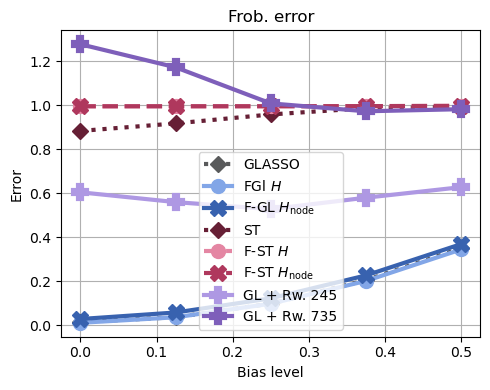

In [74]:
# ------------------------
circ_args  = { 'marker':'o', 'markersize':10, 'markeredgewidth':1 }
cross_args = { 'marker':'X', 'markersize':12, 'markeredgewidth':1 }
diam_args = { 'marker':'D', 'markersize':8, 'markeredgewidth':1 }
plus_args = { 'marker':'P', 'markersize':10, 'markeredgewidth':3 }

solid_args = { 'linestyle':'-', 'linewidth':3 }
dash_args = { 'linestyle':'--', 'linewidth':3 }
dotted_args = { 'linestyle':':', 'linewidth':3 }
# ------------------------


# ------------------------
x_label = r'Bias level'
x_range = BIAS_RANGE 
# ------------------------

# ------------------------
y_label = 'Error'
fig = plt.figure(figsize=(5,4))
ax = fig.subplots()
# ------------------------

# ------------------------
c = grays[18]
label = 'GLASSO'
y_range = frob_all['gl'].mean(0)
mkr_args = diam_args
line_args = dotted_args

plt_args = mkr_args | line_args | {'c':c, 'label':label}
ax.plot(x_range,y_range, **plt_args )
# ------------------------

# ------------------------
c = blues[6]
label = r'FGl $H$'
y_range = frob_all['dp'].mean(0)
mkr_args = circ_args
line_args = solid_args

plt_args = mkr_args | line_args | {'c':c, 'label':label}
ax.plot(x_range,y_range, **plt_args )
# ------------------------


# ------------------------
c = blues[14]
label = r'F-GL $H_{\mathrm{node}}$'
y_range = frob_all['nwdp'].mean(0)
mkr_args = cross_args
line_args = solid_args

plt_args = mkr_args | line_args | {'c':c, 'label':label}
ax.plot(x_range,y_range, **plt_args )
# ------------------------


# ------------------------
c = reds[20]
label = r'ST'
y_range = frob_all['st'].mean(0)
mkr_args = diam_args
line_args = dotted_args

plt_args = mkr_args | line_args | {'c':c, 'label':label}
ax.plot(x_range,y_range, **plt_args )
# ------------------------


# ------------------------
c = reds[6]
label = r'F-ST $H$'
y_range = frob_all['stdp'].mean(0)
mkr_args = circ_args
line_args = dash_args

plt_args = mkr_args | line_args | {'c':c, 'label':label}
ax.plot(x_range,y_range, **plt_args )
# ------------------------


# ------------------------
c = reds[14]
label = r'F-ST $H_{\mathrm{node}}$'
y_range = frob_all['stnwdp'].mean(0)
mkr_args = cross_args
line_args = dash_args

plt_args = mkr_args | line_args | {'c':c, 'label':label}
ax.plot(x_range,y_range, **plt_args )
# ------------------------


# ------------------------
c = purples[6]
label = r'GL + Rw. '+f'{rwlo}'
y_range = frob_all['rwlo'].mean(0)
mkr_args = plus_args
line_args = solid_args

plt_args = mkr_args | line_args | {'c':c, 'label':label}
ax.plot(x_range,y_range, **plt_args )
# ------------------------


# ------------------------
c = purples[14]
label = r'GL + Rw. '+f'{rwhi}'
y_range = frob_all['rwhi'].mean(0)
mkr_args = plus_args
line_args = solid_args

plt_args = mkr_args | line_args | {'c':c, 'label':label}
ax.plot(x_range,y_range, **plt_args )
# ------------------------
ax.set_title('Frob. error')

ax.set_xlabel(x_label)
ax.set_ylabel(y_label)
ax.legend()
ax.grid(True)
fig.tight_layout()


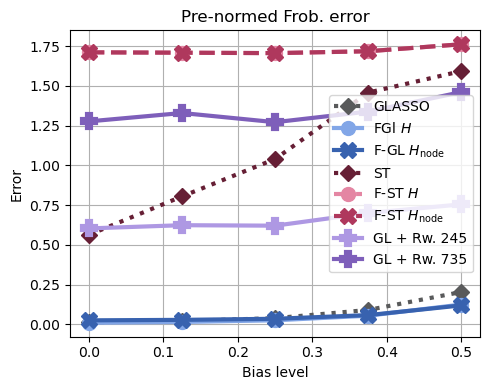

In [75]:
# ------------------------
circ_args  = { 'marker':'o', 'markersize':10, 'markeredgewidth':1 }
cross_args = { 'marker':'X', 'markersize':12, 'markeredgewidth':1 }
diam_args = { 'marker':'D', 'markersize':8, 'markeredgewidth':1 }
plus_args = { 'marker':'P', 'markersize':10, 'markeredgewidth':3 }

solid_args = { 'linestyle':'-', 'linewidth':3 }
dash_args = { 'linestyle':'--', 'linewidth':3 }
dotted_args = { 'linestyle':':', 'linewidth':3 }
# ------------------------


# ------------------------
x_label = r'Bias level'
x_range = BIAS_RANGE 
# ------------------------

# ------------------------
y_label = 'Error'
fig = plt.figure(figsize=(5,4))
ax = fig.subplots()
# ------------------------

# ------------------------
c = grays[18]
label = 'GLASSO'
y_range = frob_normed_all['gl'].mean(0)
mkr_args = diam_args
line_args = dotted_args

plt_args = mkr_args | line_args | {'c':c, 'label':label}
ax.plot(x_range,y_range, **plt_args )
# ------------------------

# ------------------------
c = blues[6]
label = r'FGl $H$'
y_range = frob_normed_all['dp'].mean(0)
mkr_args = circ_args
line_args = solid_args

plt_args = mkr_args | line_args | {'c':c, 'label':label}
ax.plot(x_range,y_range, **plt_args )
# ------------------------


# ------------------------
c = blues[14]
label = r'F-GL $H_{\mathrm{node}}$'
y_range = frob_normed_all['nwdp'].mean(0)
mkr_args = cross_args
line_args = solid_args

plt_args = mkr_args | line_args | {'c':c, 'label':label}
ax.plot(x_range,y_range, **plt_args )
# ------------------------


# ------------------------
c = reds[20]
label = r'ST'
y_range = frob_normed_all['st'].mean(0)
mkr_args = diam_args
line_args = dotted_args

plt_args = mkr_args | line_args | {'c':c, 'label':label}
ax.plot(x_range,y_range, **plt_args )
# ------------------------


# ------------------------
c = reds[6]
label = r'F-ST $H$'
y_range = frob_normed_all['stdp'].mean(0)
mkr_args = circ_args
line_args = dash_args

plt_args = mkr_args | line_args | {'c':c, 'label':label}
ax.plot(x_range,y_range, **plt_args )
# ------------------------


# ------------------------
c = reds[14]
label = r'F-ST $H_{\mathrm{node}}$'
y_range = frob_normed_all['stnwdp'].mean(0)
mkr_args = cross_args
line_args = dash_args

plt_args = mkr_args | line_args | {'c':c, 'label':label}
ax.plot(x_range,y_range, **plt_args )
# ------------------------


# ------------------------
c = purples[6]
label = r'GL + Rw. '+f'{rwlo}'
y_range = frob_normed_all['rwlo'].mean(0)
mkr_args = plus_args
line_args = solid_args

plt_args = mkr_args | line_args | {'c':c, 'label':label}
ax.plot(x_range,y_range, **plt_args )
# ------------------------


# ------------------------
c = purples[14]
label = r'GL + Rw. '+f'{rwhi}'
y_range = frob_normed_all['rwhi'].mean(0)
mkr_args = plus_args
line_args = solid_args

plt_args = mkr_args | line_args | {'c':c, 'label':label}
ax.plot(x_range,y_range, **plt_args )
# ------------------------
ax.set_title('Pre-normed Frob. error')

ax.set_xlabel(x_label)
ax.set_ylabel(y_label)
ax.legend()
ax.grid(True)
fig.tight_layout()


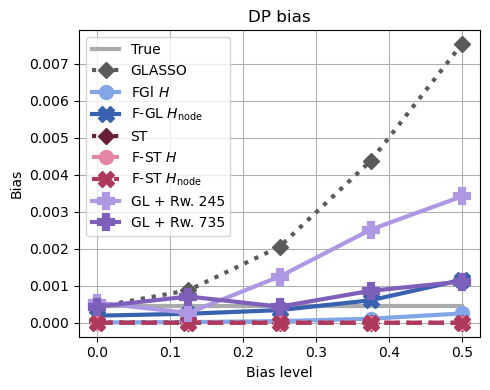

In [76]:
# ------------------------
circ_args  = { 'marker':'o', 'markersize':10, 'markeredgewidth':1 }
cross_args = { 'marker':'X', 'markersize':12, 'markeredgewidth':1 }
diam_args = { 'marker':'D', 'markersize':8, 'markeredgewidth':1 }
plus_args = { 'marker':'P', 'markersize':10, 'markeredgewidth':3 }

solid_args = { 'linestyle':'-', 'linewidth':3 }
dash_args = { 'linestyle':'--', 'linewidth':3 }
dotted_args = { 'linestyle':':', 'linewidth':3 }
# ------------------------


# ------------------------
x_label = r'Bias level'
x_range = BIAS_RANGE 
# ------------------------

# ------------------------
y_label = 'Bias'
fig = plt.figure(figsize=(5,4))
ax = fig.subplots()
# ------------------------

# ------------------------
c = grays[8]
label = 'True'
y_range = np.ones(num_params) * np.mean(bias_true)
mkr_args = {'marker':''} 
line_args = solid_args

plt_args = mkr_args | line_args | {'c':c, 'label':label}
ax.plot(x_range,y_range, **plt_args )
# ------------------------

# ------------------------
c = grays[18]
label = 'GLASSO'
y_range = bias_all['gl'].mean(0)
mkr_args = diam_args
line_args = dotted_args

plt_args = mkr_args | line_args | {'c':c, 'label':label}
ax.plot(x_range,y_range, **plt_args )
# ------------------------

# ------------------------
c = blues[6]
label = r'FGl $H$'
y_range = bias_all['dp'].mean(0)
mkr_args = circ_args
line_args = solid_args

plt_args = mkr_args | line_args | {'c':c, 'label':label}
ax.plot(x_range,y_range, **plt_args )
# ------------------------


# ------------------------
c = blues[14]
label = r'F-GL $H_{\mathrm{node}}$'
y_range = bias_all['nwdp'].mean(0)
mkr_args = cross_args
line_args = solid_args

plt_args = mkr_args | line_args | {'c':c, 'label':label}
ax.plot(x_range,y_range, **plt_args )
# ------------------------


# ------------------------
c = reds[20]
label = r'ST'
y_range = bias_all['st'].mean(0)
mkr_args = diam_args
line_args = dotted_args

plt_args = mkr_args | line_args | {'c':c, 'label':label}
ax.plot(x_range,y_range, **plt_args )
# ------------------------


# ------------------------
c = reds[6]
label = r'F-ST $H$'
y_range = bias_all['stdp'].mean(0)
mkr_args = circ_args
line_args = dash_args

plt_args = mkr_args | line_args | {'c':c, 'label':label}
ax.plot(x_range,y_range, **plt_args )
# ------------------------


# ------------------------
c = reds[14]
label = r'F-ST $H_{\mathrm{node}}$'
y_range = bias_all['stnwdp'].mean(0)
mkr_args = cross_args
line_args = dash_args

plt_args = mkr_args | line_args | {'c':c, 'label':label}
ax.plot(x_range,y_range, **plt_args )
# ------------------------


# ------------------------
c = purples[6]
label = r'GL + Rw. '+f'{rwlo}'
y_range = bias_all['rwlo'].mean(0)
mkr_args = plus_args
line_args = solid_args

plt_args = mkr_args | line_args | {'c':c, 'label':label}
ax.plot(x_range,y_range, **plt_args )
# ------------------------


# ------------------------
c = purples[14]
label = r'GL + Rw. '+f'{rwhi}'
y_range = bias_all['rwhi'].mean(0)
mkr_args = plus_args
line_args = solid_args

plt_args = mkr_args | line_args | {'c':c, 'label':label}
ax.plot(x_range,y_range, **plt_args )
# ------------------------
ax.set_title('DP bias')

ax.set_xlabel(x_label)
ax.set_ylabel(y_label)
ax.legend()
ax.grid(True)
fig.tight_layout()



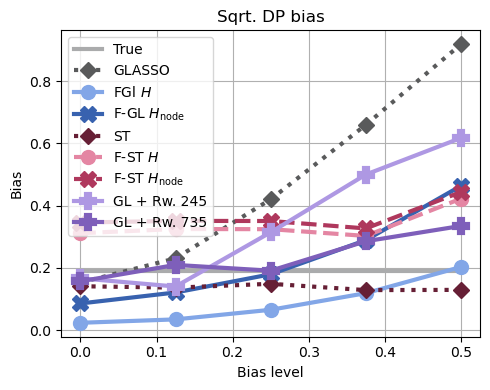

In [77]:
# ------------------------
circ_args  = { 'marker':'o', 'markersize':10, 'markeredgewidth':1 }
cross_args = { 'marker':'X', 'markersize':12, 'markeredgewidth':1 }
diam_args = { 'marker':'D', 'markersize':8, 'markeredgewidth':1 }
plus_args = { 'marker':'P', 'markersize':10, 'markeredgewidth':3 }

solid_args = { 'linestyle':'-', 'linewidth':3 }
dash_args = { 'linestyle':'--', 'linewidth':3 }
dotted_args = { 'linestyle':':', 'linewidth':3 }
# ------------------------


# ------------------------
x_label = r'Bias level'
x_range = BIAS_RANGE 
# ------------------------

# ------------------------
y_label = 'Bias'
fig = plt.figure(figsize=(5,4))
ax = fig.subplots()
# ------------------------

# ------------------------
c = grays[8]
label = 'True'
y_range = np.ones(num_params) * np.mean(sqrt_bias_true)
mkr_args = {'marker':''} 
line_args = solid_args

plt_args = mkr_args | line_args | {'c':c, 'label':label}
ax.plot(x_range,y_range, **plt_args )
# ------------------------

# ------------------------
c = grays[18]
label = 'GLASSO'
y_range = sqrt_bias_all['gl'].mean(0)
mkr_args = diam_args
line_args = dotted_args

plt_args = mkr_args | line_args | {'c':c, 'label':label}
ax.plot(x_range,y_range, **plt_args )
# ------------------------

# ------------------------
c = blues[6]
label = r'FGl $H$'
y_range = sqrt_bias_all['dp'].mean(0)
mkr_args = circ_args
line_args = solid_args

plt_args = mkr_args | line_args | {'c':c, 'label':label}
ax.plot(x_range,y_range, **plt_args )
# ------------------------


# ------------------------
c = blues[14]
label = r'F-GL $H_{\mathrm{node}}$'
y_range = sqrt_bias_all['nwdp'].mean(0)
mkr_args = cross_args
line_args = solid_args

plt_args = mkr_args | line_args | {'c':c, 'label':label}
ax.plot(x_range,y_range, **plt_args )
# ------------------------


# ------------------------
c = reds[20]
label = r'ST'
y_range = sqrt_bias_all['st'].mean(0)
mkr_args = diam_args
line_args = dotted_args

plt_args = mkr_args | line_args | {'c':c, 'label':label}
ax.plot(x_range,y_range, **plt_args )
# ------------------------


# ------------------------
c = reds[6]
label = r'F-ST $H$'
y_range = sqrt_bias_all['stdp'].mean(0)
mkr_args = circ_args
line_args = dash_args

plt_args = mkr_args | line_args | {'c':c, 'label':label}
ax.plot(x_range,y_range, **plt_args )
# ------------------------


# ------------------------
c = reds[14]
label = r'F-ST $H_{\mathrm{node}}$'
y_range = sqrt_bias_all['stnwdp'].mean(0)
mkr_args = cross_args
line_args = dash_args

plt_args = mkr_args | line_args | {'c':c, 'label':label}
ax.plot(x_range,y_range, **plt_args )
# ------------------------


# ------------------------
c = purples[6]
label = r'GL + Rw. '+f'{rwlo}'
y_range = sqrt_bias_all['rwlo'].mean(0)
mkr_args = plus_args
line_args = solid_args

plt_args = mkr_args | line_args | {'c':c, 'label':label}
ax.plot(x_range,y_range, **plt_args )
# ------------------------


# ------------------------
c = purples[14]
label = r'GL + Rw. '+f'{rwhi}'
y_range = sqrt_bias_all['rwhi'].mean(0)
mkr_args = plus_args
line_args = solid_args

plt_args = mkr_args | line_args | {'c':c, 'label':label}
ax.plot(x_range,y_range, **plt_args )
# ------------------------
ax.set_title('Sqrt. DP bias')

ax.set_xlabel(x_label)
ax.set_ylabel(y_label)
ax.legend()
ax.grid(True)
fig.tight_layout()


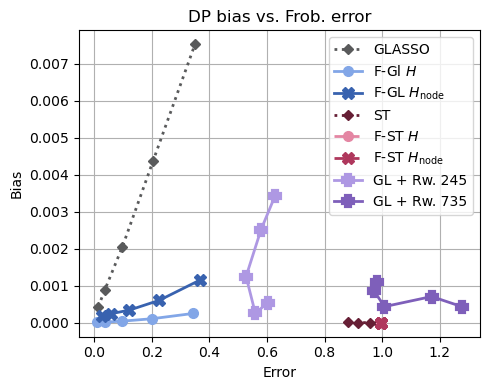

In [78]:
# ------------------------
circ_args  = { 'marker':'o', 'markersize':7, 'markeredgewidth':1 }
cross_args = { 'marker':'X', 'markersize':9, 'markeredgewidth':1 }
diam_args = { 'marker':'D', 'markersize':5, 'markeredgewidth':1 }
plus_args = { 'marker':'P', 'markersize':7, 'markeredgewidth':3 }

solid_args = { 'linestyle':'-', 'linewidth':2 }
dash_args = { 'linestyle':'--', 'linewidth':2 }
dotted_args = { 'linestyle':':', 'linewidth':2 }
# ------------------------


# ------------------------
x_label = 'Error'
y_label = 'Bias'
t_range = BIAS_RANGE
# ------------------------

# ------------------------
fig = plt.figure(figsize=(5,4))
ax = fig.subplots()
# ------------------------


# ------------------------
c = grays[18]
label = 'GLASSO'
mkr_args = diam_args
line_args = dotted_args
x_range = frob_all['gl'].mean(0)
y_range = bias_all['gl'].mean(0)
plt_args = mkr_args | line_args | {'c':c, 'label':label}
ax.plot( x_range,y_range, **plt_args )
# ------------------------


# ------------------------
c = blues[6]
label = r'F-Gl $H$'
mkr_args = circ_args
line_args = solid_args
x_range = frob_all['dp'].mean(0)
y_range = bias_all['dp'].mean(0)
plt_args = mkr_args | line_args | {'c':c, 'label':label}
ax.plot( x_range,y_range, **plt_args )
# ------------------------


# ------------------------
c = blues[14]
label = r'F-GL $H_{\mathrm{node}}$'
mkr_args = cross_args
line_args = solid_args

x_range = frob_all['nwdp'].mean(0)
y_range = bias_all['nwdp'].mean(0)
plt_args = mkr_args | line_args | {'c':c, 'label':label}
ax.plot( x_range,y_range, **plt_args )
# ------------------------


# ------------------------
c = reds[20]
label = r'ST'
mkr_args = diam_args
line_args = dotted_args

x_range = frob_all['st'].mean(0)
y_range = bias_all['st'].mean(0)
plt_args = mkr_args | line_args | {'c':c, 'label':label}
ax.plot( x_range,y_range, **plt_args )
# ------------------------


# ------------------------
c = reds[6]
label = r'F-ST $H$'
mkr_args = circ_args
line_args = dash_args

x_range = frob_all['stdp'].mean(0)
y_range = bias_all['stdp'].mean(0)
plt_args = mkr_args | line_args | {'c':c, 'label':label}
ax.plot( x_range,y_range, **plt_args )
# ------------------------


# ------------------------
c = reds[14]
label = r'F-ST $H_{\mathrm{node}}$'
mkr_args = cross_args
line_args = dash_args

x_range = frob_all['stnwdp'].mean(0)
y_range = bias_all['stnwdp'].mean(0)
plt_args = mkr_args | line_args | {'c':c, 'label':label}
ax.plot( x_range,y_range, **plt_args )
# ------------------------


# ------------------------
c = purples[6]
label = r'GL + Rw. '+f'{rwlo}'
mkr_args = plus_args
line_args = solid_args

x_range = frob_all['rwlo'].mean(0)
y_range = bias_all['rwlo'].mean(0)
plt_args = mkr_args | line_args | {'c':c, 'label':label}
ax.plot( x_range,y_range, **plt_args )
# ------------------------


# ------------------------
c = purples[14]
label = r'GL + Rw. '+f'{rwhi}'
mkr_args = plus_args
line_args = solid_args

x_range = frob_all['rwhi'].mean(0)
y_range = bias_all['rwhi'].mean(0)
plt_args = mkr_args | line_args | {'c':c, 'label':label}
ax.plot( x_range,y_range, **plt_args )
# ------------------------


# ------------------------
ax.set_title('DP bias vs. Frob. error')

ax.grid(True)
ax.legend()
ax.set_xlabel(x_label)
ax.set_ylabel(y_label)
fig.tight_layout()
# ------------------------



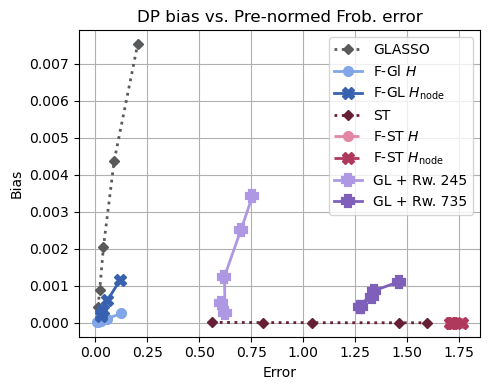

In [79]:
# ------------------------
circ_args  = { 'marker':'o', 'markersize':7, 'markeredgewidth':1 }
cross_args = { 'marker':'X', 'markersize':9, 'markeredgewidth':1 }
diam_args = { 'marker':'D', 'markersize':5, 'markeredgewidth':1 }
plus_args = { 'marker':'P', 'markersize':7, 'markeredgewidth':3 }

solid_args = { 'linestyle':'-', 'linewidth':2 }
dash_args = { 'linestyle':'--', 'linewidth':2 }
dotted_args = { 'linestyle':':', 'linewidth':2 }
# ------------------------


# ------------------------
x_label = 'Error'
y_label = 'Bias'
t_range = BIAS_RANGE 
# ------------------------

# ------------------------
fig = plt.figure(figsize=(5,4))
ax = fig.subplots()
# ------------------------


# ------------------------
c = grays[18]
label = 'GLASSO'
mkr_args = diam_args
line_args = dotted_args
x_range = frob_normed_all['gl'].mean(0)
y_range = bias_all['gl'].mean(0)
plt_args = mkr_args | line_args | {'c':c, 'label':label}
ax.plot( x_range,y_range, **plt_args )
# ------------------------


# ------------------------
c = blues[6]
label = r'F-Gl $H$'
mkr_args = circ_args
line_args = solid_args
x_range = frob_normed_all['dp'].mean(0)
y_range = bias_all['dp'].mean(0)
plt_args = mkr_args | line_args | {'c':c, 'label':label}
ax.plot( x_range,y_range, **plt_args )
# ------------------------


# ------------------------
c = blues[14]
label = r'F-GL $H_{\mathrm{node}}$'
mkr_args = cross_args
line_args = solid_args

x_range = frob_normed_all['nwdp'].mean(0)
y_range = bias_all['nwdp'].mean(0)
plt_args = mkr_args | line_args | {'c':c, 'label':label}
ax.plot( x_range,y_range, **plt_args )
# ------------------------


# ------------------------
c = reds[20]
label = r'ST'
mkr_args = diam_args
line_args = dotted_args

x_range = frob_normed_all['st'].mean(0)
y_range = bias_all['st'].mean(0)
plt_args = mkr_args | line_args | {'c':c, 'label':label}
ax.plot( x_range,y_range, **plt_args )
# ------------------------


# ------------------------
c = reds[6]
label = r'F-ST $H$'
mkr_args = circ_args
line_args = dash_args

x_range = frob_normed_all['stdp'].mean(0)
y_range = bias_all['stdp'].mean(0)
plt_args = mkr_args | line_args | {'c':c, 'label':label}
ax.plot( x_range,y_range, **plt_args )
# ------------------------


# ------------------------
c = reds[14]
label = r'F-ST $H_{\mathrm{node}}$'
mkr_args = cross_args
line_args = dash_args

x_range = frob_normed_all['stnwdp'].mean(0)
y_range = bias_all['stnwdp'].mean(0)
plt_args = mkr_args | line_args | {'c':c, 'label':label}
ax.plot( x_range,y_range, **plt_args )
# ------------------------


# ------------------------
c = purples[6]
label = r'GL + Rw. '+f'{rwlo}'
mkr_args = plus_args
line_args = solid_args

x_range = frob_normed_all['rwlo'].mean(0)
y_range = bias_all['rwlo'].mean(0)
plt_args = mkr_args | line_args | {'c':c, 'label':label}
ax.plot( x_range,y_range, **plt_args )
# ------------------------


# ------------------------
c = purples[14]
label = r'GL + Rw. '+f'{rwhi}'
mkr_args = plus_args
line_args = solid_args

x_range = frob_normed_all['rwhi'].mean(0)
y_range = bias_all['rwhi'].mean(0)
plt_args = mkr_args | line_args | {'c':c, 'label':label}
ax.plot( x_range,y_range, **plt_args )
# ------------------------


# ------------------------
ax.set_title('DP bias vs. Pre-normed Frob. error')
ax.grid(True)
ax.legend()
ax.set_xlabel(x_label)
ax.set_ylabel(y_label)
fig.tight_layout()
# ------------------------




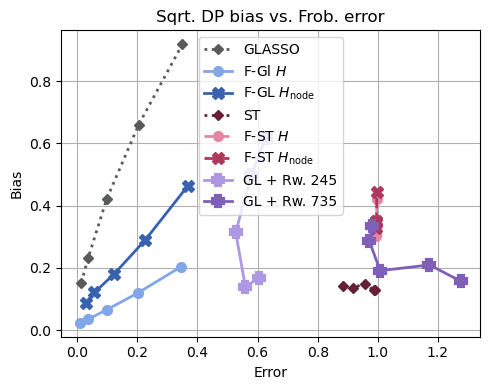

In [80]:
# ------------------------
circ_args  = { 'marker':'o', 'markersize':7, 'markeredgewidth':1 }
cross_args = { 'marker':'X', 'markersize':9, 'markeredgewidth':1 }
diam_args = { 'marker':'D', 'markersize':5, 'markeredgewidth':1 }
plus_args = { 'marker':'P', 'markersize':7, 'markeredgewidth':3 }

solid_args = { 'linestyle':'-', 'linewidth':2 }
dash_args = { 'linestyle':'--', 'linewidth':2 }
dotted_args = { 'linestyle':':', 'linewidth':2 }
# ------------------------


# ------------------------
x_label = 'Error'
y_label = 'Bias'
t_range = BIAS_RANGE
# ------------------------

# ------------------------
fig = plt.figure(figsize=(5,4))
ax = fig.subplots()
# ------------------------


# ------------------------
c = grays[18]
label = 'GLASSO'
mkr_args = diam_args
line_args = dotted_args
x_range = frob_all['gl'].mean(0)
y_range = sqrt_bias_all['gl'].mean(0)
plt_args = mkr_args | line_args | {'c':c, 'label':label}
ax.plot( x_range,y_range, **plt_args )
# ------------------------


# ------------------------
c = blues[6]
label = r'F-Gl $H$'
mkr_args = circ_args
line_args = solid_args
x_range = frob_all['dp'].mean(0)
y_range = sqrt_bias_all['dp'].mean(0)
plt_args = mkr_args | line_args | {'c':c, 'label':label}
ax.plot( x_range,y_range, **plt_args )
# ------------------------


# ------------------------
c = blues[14]
label = r'F-GL $H_{\mathrm{node}}$'
mkr_args = cross_args
line_args = solid_args

x_range = frob_all['nwdp'].mean(0)
y_range = sqrt_bias_all['nwdp'].mean(0)
plt_args = mkr_args | line_args | {'c':c, 'label':label}
ax.plot( x_range,y_range, **plt_args )
# ------------------------


# ------------------------
c = reds[20]
label = r'ST'
mkr_args = diam_args
line_args = dotted_args

x_range = frob_all['st'].mean(0)
y_range = sqrt_bias_all['st'].mean(0)
plt_args = mkr_args | line_args | {'c':c, 'label':label}
ax.plot( x_range,y_range, **plt_args )
# ------------------------


# ------------------------
c = reds[6]
label = r'F-ST $H$'
mkr_args = circ_args
line_args = dash_args

x_range = frob_all['stdp'].mean(0)
y_range = sqrt_bias_all['stdp'].mean(0)
plt_args = mkr_args | line_args | {'c':c, 'label':label}
ax.plot( x_range,y_range, **plt_args )
# ------------------------


# ------------------------
c = reds[14]
label = r'F-ST $H_{\mathrm{node}}$'
mkr_args = cross_args
line_args = dash_args

x_range = frob_all['stnwdp'].mean(0)
y_range = sqrt_bias_all['stnwdp'].mean(0)
plt_args = mkr_args | line_args | {'c':c, 'label':label}
ax.plot( x_range,y_range, **plt_args )
# ------------------------


# ------------------------
c = purples[6]
label = r'GL + Rw. '+f'{rwlo}'
mkr_args = plus_args
line_args = solid_args

x_range = frob_all['rwlo'].mean(0)
y_range = sqrt_bias_all['rwlo'].mean(0)
plt_args = mkr_args | line_args | {'c':c, 'label':label}
ax.plot( x_range,y_range, **plt_args )
# ------------------------


# ------------------------
c = purples[14]
label = r'GL + Rw. '+f'{rwhi}'
mkr_args = plus_args
line_args = solid_args

x_range = frob_all['rwhi'].mean(0)
y_range = sqrt_bias_all['rwhi'].mean(0)
plt_args = mkr_args | line_args | {'c':c, 'label':label}
ax.plot( x_range,y_range, **plt_args )
# ------------------------


# ------------------------
ax.set_title('Sqrt. DP bias vs. Frob. error')

ax.grid(True)
ax.legend()
ax.set_xlabel(x_label)
ax.set_ylabel(y_label)
fig.tight_layout()
# ------------------------






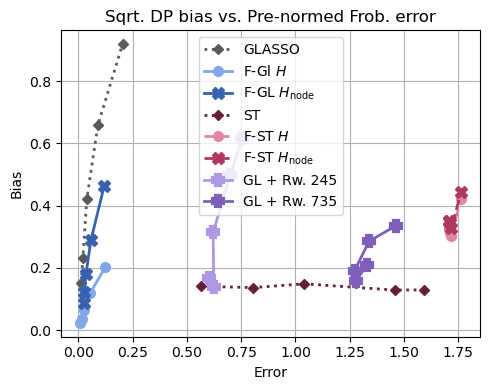

In [81]:
# ------------------------
circ_args  = { 'marker':'o', 'markersize':7, 'markeredgewidth':1 }
cross_args = { 'marker':'X', 'markersize':9, 'markeredgewidth':1 }
diam_args = { 'marker':'D', 'markersize':5, 'markeredgewidth':1 }
plus_args = { 'marker':'P', 'markersize':7, 'markeredgewidth':3 }

solid_args = { 'linestyle':'-', 'linewidth':2 }
dash_args = { 'linestyle':'--', 'linewidth':2 }
dotted_args = { 'linestyle':':', 'linewidth':2 }
# ------------------------


# ------------------------
x_label = 'Error'
y_label = 'Bias'
t_range = BIAS_RANGE
# ------------------------

# ------------------------
fig = plt.figure(figsize=(5,4))
ax = fig.subplots()
# ------------------------


# ------------------------
c = grays[18]
label = 'GLASSO'
mkr_args = diam_args
line_args = dotted_args
x_range = frob_normed_all['gl'].mean(0)
y_range = sqrt_bias_all['gl'].mean(0)
plt_args = mkr_args | line_args | {'c':c, 'label':label}
ax.plot( x_range,y_range, **plt_args )
# ------------------------


# ------------------------
c = blues[6]
label = r'F-Gl $H$'
mkr_args = circ_args
line_args = solid_args
x_range = frob_normed_all['dp'].mean(0)
y_range = sqrt_bias_all['dp'].mean(0)
plt_args = mkr_args | line_args | {'c':c, 'label':label}
ax.plot( x_range,y_range, **plt_args )
# ------------------------


# ------------------------
c = blues[14]
label = r'F-GL $H_{\mathrm{node}}$'
mkr_args = cross_args
line_args = solid_args

x_range = frob_normed_all['nwdp'].mean(0)
y_range = sqrt_bias_all['nwdp'].mean(0)
plt_args = mkr_args | line_args | {'c':c, 'label':label}
ax.plot( x_range,y_range, **plt_args )
# ------------------------


# ------------------------
c = reds[20]
label = r'ST'
mkr_args = diam_args
line_args = dotted_args

x_range = frob_normed_all['st'].mean(0)
y_range = sqrt_bias_all['st'].mean(0)
plt_args = mkr_args | line_args | {'c':c, 'label':label}
ax.plot( x_range,y_range, **plt_args )
# ------------------------


# ------------------------
c = reds[6]
label = r'F-ST $H$'
mkr_args = circ_args
line_args = dash_args

x_range = frob_normed_all['stdp'].mean(0)
y_range = sqrt_bias_all['stdp'].mean(0)
plt_args = mkr_args | line_args | {'c':c, 'label':label}
ax.plot( x_range,y_range, **plt_args )
# ------------------------


# ------------------------
c = reds[14]
label = r'F-ST $H_{\mathrm{node}}$'
mkr_args = cross_args
line_args = dash_args

x_range = frob_normed_all['stnwdp'].mean(0)
y_range = sqrt_bias_all['stnwdp'].mean(0)
plt_args = mkr_args | line_args | {'c':c, 'label':label}
ax.plot( x_range,y_range, **plt_args )
# ------------------------


# ------------------------
c = purples[6]
label = r'GL + Rw. '+f'{rwlo}'
mkr_args = plus_args
line_args = solid_args

x_range = frob_normed_all['rwlo'].mean(0)
y_range = sqrt_bias_all['rwlo'].mean(0)
plt_args = mkr_args | line_args | {'c':c, 'label':label}
ax.plot( x_range,y_range, **plt_args )
# ------------------------


# ------------------------
c = purples[14]
label = r'GL + Rw. '+f'{rwhi}'
mkr_args = plus_args
line_args = solid_args

x_range = frob_normed_all['rwhi'].mean(0)
y_range = sqrt_bias_all['rwhi'].mean(0)
plt_args = mkr_args | line_args | {'c':c, 'label':label}
ax.plot( x_range,y_range, **plt_args )
# ------------------------


# ------------------------
ax.set_title('Sqrt. DP bias vs. Pre-normed Frob. error')
ax.grid(True)
ax.legend()
ax.set_xlabel(x_label)
ax.set_ylabel(y_label)
fig.tight_layout()
# ------------------------





In [90]:
A = list(pd.read_csv('klas12b/klas12b-net-1.dat',sep=',',header=None).to_numpy())
A = np.array(list(map(lambda a:np.array(a[0].split()).astype(int), A)))
A[A==9] = 0
A[A==10] = 0
A1 = (A + A.T)/2

A = list(pd.read_csv('klas12b/klas12b-net-2.dat',sep=',',header=None).to_numpy())
A = np.array(list(map(lambda a:np.array(a[0].split()).astype(int), A)))
A[A==9] = 0
A[A==10] = 0
A2 = (A + A.T)/2

A = list(pd.read_csv('klas12b/klas12b-net-3.dat',sep=',',header=None).to_numpy())
A = np.array(list(map(lambda a:np.array(a[0].split()).astype(int), A)))
A[A==9] = 0
A[A==10] = 0
A3 = (A + A.T)/2

A = list(pd.read_csv('klas12b/klas12b-net-4.dat',sep=',',header=None).to_numpy())
A = np.array(list(map(lambda a:np.array(a[0].split()).astype(int), A)))
A[A==9] = 0
A[A==10] = 0
A4 = (A + A.T)/2

# Overall friendship networks
A = (A1 + A2 + A3 + A4)

# Groups
demographics = pd.read_csv('klas12b/klas12b-demographics.dat',sep=' ',header=None).iloc[:,1:]
z = demographics[1].to_numpy()-1
z = demographics[2].to_numpy()-11
z = np.maximum(demographics[3].to_numpy()-1,0)
z = np.maximum(demographics[4].to_numpy()-1,0)

sort_by_group = np.argsort(z)
z = z[sort_by_group]
g = len(np.unique(z))
Z = np.eye(g)[z].T
g,p = Z.shape
p_grp = [int(np.sum(Z[a])) for a in range(g)]
mask_Z = [[Z[a][:,None]*Z[b][None] for b in range(g)] for a in range(g)]
ccalZ = [[np.where(mask_Z[a][b]==1) for b in range(g)] for a in range(g)]

# Data
delinquency = pd.read_csv('klas12b/klas12b-delinquency.dat',sep=' ',header=None).iloc[:,1:]
alcohol = pd.read_csv('klas12b/klas12b-alcohol.dat',sep=' ',header=None).iloc[:,1:]
X = np.concatenate([delinquency.to_numpy(),alcohol.to_numpy()],axis=1).T
X = delinquency.to_numpy().T
# X = alcohol.to_numpy().T
X = X[:,sort_by_group]
n,p = X.shape

X = (X - X.mean(axis=1)[:,None]) / X.std(axis=1)[:,None]
Sigma_hat = X.T@X/n

